In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.covariance import shrunk_covariance, ledoit_wolf, MinCovDet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import mahalanobis
from joblib import dump

In [2]:
tx_path = "./data/train_transaction.csv"
id_path = "./data/train_identity.csv"

## Lectura de datos

In [3]:
df_tx = pd.read_csv(tx_path)
df_id = pd.read_csv(id_path)

In [4]:
df_tx.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Unión de datasets

In [5]:
df = pd.merge(df_id, df_tx, how='inner', on='TransactionID')
df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(144233, 434)

## Limpieza de datos

Se eliminan las columnas que tengan más del 10% de valores de nulos. Después, se eliminan todos los registros que tengan valores nulos

In [7]:
thresh_col = df.shape[0]*0.9
df.dropna(axis=1, thresh=thresh_col, inplace=True)
df.columns
cols_to_preserve = ['TransactionID','id_01','id_02','id_05','id_06','id_11','id_12','id_15','id_17','id_19','id_20','id_28','id_29','id_31','id_35','id_36','id_37','id_38','DeviceType','isFraud','TransactionDT','TransactionAmt','ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','V95','V96','V97','V98','V99','V100','V101','V102','V103','V104','V105','V106','V107','V108','V109','V110','V111','V112','V113','V114','V115','V116','V117','V118','V119','V120','V121','V122','V123','V124','V125','V126','V127','V128','V129','V130','V131','V132','V133','V134','V135','V136','V137','V167','V168','V169','V170','V171','V172','V173','V174','V175','V176','V177','V178','V179','V180','V181','V182','V183','V184','V185','V186','V187','V188','V189','V190','V191','V192','V193','V194','V195','V196','V197','V198','V199','V200','V201','V202','V203','V204','V205','V206','V207','V208','V209','V210','V211','V212','V213','V214','V215','V216','V217','V218','V219','V220','V221','V222','V223','V224','V225','V226','V227','V228','V229','V230','V231','V232','V233','V234','V235','V236','V237','V238','V239','V240','V241','V242','V243','V244','V245','V246','V247','V248','V249','V250','V251','V252','V253','V254','V255','V256','V257','V258','V259','V260','V261','V262','V263','V264','V265','V266','V267','V268','V269','V270','V271','V272','V273','V274','V275','V276','V277','V278','V279','V280','V281','V282','V283','V284','V285','V286','V287','V288','V289','V290','V291','V292','V293','V294','V295','V296','V297','V298','V299','V300','V301','V302','V303','V304','V305','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Columns: 244 entries, TransactionID to V321
dtypes: float64(225), int64(4), object(15)
memory usage: 269.6+ MB


In [8]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102800 entries, 0 to 102799
Columns: 244 entries, TransactionID to V321
dtypes: float64(225), int64(4), object(15)
memory usage: 191.4+ MB


## Desbalanceo de clase isFraud

Solo el 8.5% de los datos están clasificados como fraudulentos, lo cual supone un problema serio de desbalanceo

In [9]:
df.isFraud.value_counts() / df.shape[0] * 100

0    91.493191
1     8.506809
Name: isFraud, dtype: float64

## Estandarización de datos numéricos

Estandarizamos todos los datos númericos (con excepción de TransactionID y TransactionDT) con media 0 y varianza 1

In [10]:
numeric_df = df.select_dtypes('number').drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
columns = numeric_df.columns
numeric_df.head()

,id_01,id_02,id_05,id_06,id_11,id_17,id_19,id_20,TransactionAmt,card1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,-5.0,191631.0,0.0,0.0,100.0,121.0,410.0,142.0,75.887,16496,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
1,-5.0,221832.0,0.0,-6.0,100.0,225.0,176.0,507.0,16.495,4461,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,-10.0,116098.0,0.0,0.0,100.0,121.0,410.0,142.0,75.887,13329,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,-5.0,257037.0,0.0,0.0,100.0,225.0,484.0,507.0,42.294,15885,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,-5.0,287959.0,1.0,-11.0,100.0,225.0,254.0,507.0,3.595,12730,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [11]:
scaler = StandardScaler()
scaler_fit = scaler.fit(numeric_df)
numeric_array = scaler_fit.transform(numeric_df)

In [12]:
dump(scaler_fit, './models/scaler.joblib')

['./models/scaler.joblib']

In [13]:
new_numeric_df = pd.DataFrame(numeric_array, columns = columns)
new_numeric_df

,id_01,id_02,id_05,id_06,id_11,id_17,id_19,id_20,TransactionAmt,card1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0.358838,0.017813,-0.301125,0.360888,0.217499,-2.270046,0.446592,-1.701548,-0.130914,1.320825,...,1.481453,1.826733,1.572101,1.703516,-0.101276,-0.112061,-0.106876,0.358337,0.342541,0.350132
1,0.358838,0.207621,-0.301125,-0.088505,0.217499,1.086452,-1.240663,0.714589,-0.695065,-1.072967,...,-0.142367,-0.165480,-0.167453,-0.165828,-0.101276,-0.112061,-0.106876,-0.093533,-0.099042,-0.097247
2,0.017014,-0.456900,-0.301125,0.360888,0.217499,-2.270046,0.446592,-1.701548,-0.130914,0.690900,...,-0.142367,-0.165480,-0.167453,-0.165828,-0.101276,-0.112061,-0.106876,-0.093533,-0.099042,-0.097247
3,0.358838,0.428879,-0.301125,0.360888,0.217499,1.086452,0.980168,0.714589,-0.450006,1.199295,...,-0.142367,-0.165480,-0.167453,-0.165828,-0.101276,-0.112061,-0.106876,-0.093533,-0.099042,-0.097247
4,0.358838,0.623219,-0.100105,-0.463000,0.217499,1.086452,-0.678245,0.714589,-0.817599,0.571758,...,-0.142367,-0.165480,-0.167453,-0.165828,-0.101276,-0.112061,-0.106876,-0.093533,-0.099042,-0.097247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102795,0.358838,-0.622474,-0.301125,0.360888,0.217499,1.086452,0.569170,1.297110,-0.295955,0.876079,...,1.435434,1.770274,1.522802,1.650539,2.711934,2.465382,2.503918,-0.093533,-0.099042,-0.097247
102796,0.358838,-0.810956,-0.301125,0.360888,0.217499,1.086452,0.569170,1.297110,-0.295955,-1.332933,...,-0.142367,-0.165480,-0.167453,-0.165828,0.154471,0.122252,0.130469,-0.093533,-0.099042,-0.097247
102797,0.358838,0.405424,-0.301125,-1.886080,0.217499,1.086452,0.259119,-1.833940,-0.580775,1.249220,...,0.573816,0.713183,0.599775,0.658644,-0.101276,-0.112061,-0.106876,-0.093533,-0.099042,-0.097247
102798,-0.324810,-0.269253,-0.301125,0.360888,0.217499,1.086452,0.569170,-1.721407,-0.387476,0.430338,...,0.937436,1.159297,0.989311,1.077243,2.035040,1.845217,1.875728,-0.093533,-0.099042,-0.097247


## Eliminación de variables numéricas altamente concentradas

Estas variables se pueden considerar como constantes y no aportan información al modelo final

In [14]:
df_process = new_numeric_df.copy()
cols_to_drop = []
for col in df_process.columns:
  try:
    temp = df_process[col].value_counts().sort_values(ascending=False)
  except:
    continue
  p = (temp / df_process.shape[0]).iloc[0]
  if p > 0.8:
    cols_to_drop.append(col)
df_process.drop(cols_to_drop, axis=1, inplace=True)
len(cols_to_drop)

182

## Procesamiento de variables categóricas (Re-categorización)

In [15]:
cat_df = df.select_dtypes(exclude='number')
cat_df.head()

,id_12,id_15,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,ProductCD,card4,card6,P_emaildomain,R_emaildomain
0,NotFound,Found,Found,Found,chrome 62.0,F,F,T,T,desktop,C,mastercard,credit,gmail.com,gmail.com
1,NotFound,New,New,NotFound,chrome 62.0,F,F,T,T,desktop,C,mastercard,debit,hotmail.com,hotmail.com
2,NotFound,Found,Found,Found,chrome 62.0,F,F,T,T,desktop,C,visa,credit,gmail.com,gmail.com
3,NotFound,New,New,NotFound,chrome 62.0,F,F,T,T,desktop,C,visa,debit,outlook.com,outlook.com
4,NotFound,New,New,NotFound,chrome 62.0,F,F,T,T,desktop,C,mastercard,credit,anonymous.com,anonymous.com


In [16]:
pd.options.display.max_rows = 123
cat_df['isFraud'] = df.isFraud
temp = pd.crosstab(cat_df.id_31, cat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
temp.sort_values('Conteo', ascending=False)

<ipython-input-16-be8886e4b324>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['isFraud'] = df.isFraud


,0,1,Conteo
id_31,,,
Conteo,94055,8745,102800
chrome 63.0,16688,1250,17938
mobile safari 11.0,9636,712,10348
mobile safari generic,7825,972,8797
safari generic,6198,145,6343
ie 11.0 for desktop,5383,67,5450
chrome 65.0,4691,578,5269
chrome 64.0,4461,455,4916
chrome 63.0 for android,3898,509,4407


In [17]:
recat_df = cat_df.copy()
recat_df.id_31 = recat_df.id_31.map(lambda x: x.lower())
recat_df.id_31 = recat_df.id_31.map(lambda x: 'chrome' if 'chrome' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'firefox' if 'firefox' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'safari' if 'safari' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'edge' if 'edge' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'opera' if 'opera' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'samsung' if 'samsung' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'android' if 'android' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'google' if 'google ' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'ie' if 'ie ' in x else x)
recat_df.id_31 = recat_df.id_31.map(lambda x: 'other' if x not in 'chrome firefox safari edge opera samsung android google ie'.split() else x)
temp = pd.crosstab(recat_df.id_31, recat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
temp.sort_values('Conteo', ascending=False)

,0,1,Conteo
id_31,,,
Conteo,94055,8745,102800
chrome,51024,5673,56697
safari,26580,1995,28575
ie,5881,78,5959
firefox,4748,457,5205
edge,3496,139,3635
samsung,1410,155,1565
opera,276,137,413
android,291,75,366


In [18]:
def transform(x):
  try:
    return x[0 : x.index('.')]
  except:
    return x
recat_df.P_emaildomain = recat_df.P_emaildomain.map(transform)
temp = pd.crosstab(recat_df.P_emaildomain, recat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
choosen_cats = temp.sort_values('Conteo', ascending=False).index[1:13]
recat_df.P_emaildomain = recat_df.P_emaildomain.map(lambda x: x if x in choosen_cats else 'other')
temp = pd.crosstab(recat_df.P_emaildomain, recat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
temp.sort_values('Conteo', ascending=False)

,0,1,Conteo
P_emaildomain,,,
Conteo,94055,8745,102800
gmail,37688,5364,43052
hotmail,19121,1786,20907
anonymous,14010,358,14368
yahoo,9585,420,10005
other,3494,112,3606
aol,3152,72,3224
outlook,1806,424,2230
comcast,1577,34,1611


In [19]:
def transform(x):
  try:
    return x[0 : x.index('.')]
  except:
    return x
recat_df.R_emaildomain = recat_df.R_emaildomain.map(transform)
temp = pd.crosstab(recat_df.R_emaildomain, recat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
choosen_cats = temp.sort_values('Conteo', ascending=False).index[1:13]
recat_df.R_emaildomain = recat_df.R_emaildomain.map(lambda x: x if x in choosen_cats else 'other')
temp = pd.crosstab(recat_df.R_emaildomain, recat_df.isFraud, margins=True, margins_name="Conteo", normalize=False)
temp.columns = '0 1 Conteo'.split()
temp.sort_values('Conteo', ascending=False)

,0,1,Conteo
R_emaildomain,,,
Conteo,94055,8745,102800
gmail,37978,5380,43358
hotmail,18757,1797,20554
anonymous,15541,323,15864
yahoo,8889,418,9307
other,3163,112,3275
aol,2944,98,3042
outlook,1831,415,2246
comcast,1355,16,1371


In [20]:
final_cat_df = pd.get_dummies(recat_df, drop_first=False)
new_df_dummies = pd.concat([df_process, final_cat_df], axis=1)
for col in final_cat_df:
  final_cat_df[col] = final_cat_df.groupby(col)[col].transform(lambda x : x/np.sqrt(x.count()/len(df)))
final_cat_df.head()


,isFraud,id_12_Found,id_12_NotFound,id_15_Found,id_15_New,id_15_Unknown,id_28_Found,id_28_New,id_29_Found,id_29_NotFound,...,R_emaildomain_gmail,R_emaildomain_hotmail,R_emaildomain_icloud,R_emaildomain_live,R_emaildomain_msn,R_emaildomain_other,R_emaildomain_outlook,R_emaildomain_sbcglobal,R_emaildomain_verizon,R_emaildomain_yahoo
0,0.0,0.0,1.062241,1.460647,0.000000,0.0,1.381809,0.00000,1.393848,0.000000,...,1.539792,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,1.062241,0.000000,1.490825,0.0,0.000000,1.44901,0.000000,1.435499,...,0.000000,2.236394,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,1.062241,1.460647,0.000000,0.0,1.381809,0.00000,1.393848,0.000000,...,1.539792,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,1.062241,0.000000,1.490825,0.0,0.000000,1.44901,0.000000,1.435499,...,0.000000,0.000000,0.0,0.0,0.0,0.0,6.765372,0.0,0.0,0.0
4,0.0,0.0,1.062241,0.000000,1.490825,0.0,0.000000,1.44901,0.000000,1.435499,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [21]:
new_df = pd.concat([df_process, final_cat_df], axis=1)
new_df.head()

,id_01,id_02,id_05,id_06,id_17,id_19,id_20,TransactionAmt,card1,card2,...,R_emaildomain_gmail,R_emaildomain_hotmail,R_emaildomain_icloud,R_emaildomain_live,R_emaildomain_msn,R_emaildomain_other,R_emaildomain_outlook,R_emaildomain_sbcglobal,R_emaildomain_verizon,R_emaildomain_yahoo
0,0.358838,0.017813,-0.301125,0.360888,-2.270046,0.446592,-1.701548,-0.130914,1.320825,-0.245585,...,1.539792,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.358838,0.207621,-0.301125,-0.088505,1.086452,-1.240663,0.714589,-0.695065,-1.072967,-0.102605,...,0.000000,2.236394,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.017014,-0.456900,-0.301125,0.360888,-2.270046,0.446592,-1.701548,-0.130914,0.690900,1.103396,...,1.539792,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.358838,0.428879,-0.301125,0.360888,1.086452,0.980168,0.714589,-0.450006,1.199295,0.954200,...,0.000000,0.000000,0.0,0.0,0.0,0.0,6.765372,0.0,0.0,0.0
4,0.358838,0.623219,-0.100105,-0.463000,1.086452,-0.678245,0.714589,-0.817599,0.571758,-0.780204,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [22]:
la.cond(new_df_dummies.drop('isFraud', axis=1).cov())

8.905225326835985e+18

In [23]:
X = new_df.drop('isFraud', axis=1)
la.cond(X.cov())

446541715028821.25

In [24]:
# Preguntar a Henry sobre centrado de las variables categoricas
shrunk_S, shrinkage = ledoit_wolf(X)
la.cond(shrunk_S)

3240.5165822847885

In [25]:
mincovdet = MinCovDet(random_state=42).fit(X)
mincovdet.covariance_

c:\Users\alejo\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


array([[ 5.92359468e-01, -1.34857111e-01, -8.91574643e-04, ...,
         3.26094799e-03,  5.49057727e-04,  3.45447628e-02],
       [-1.34857111e-01,  1.00226409e+00, -1.05973868e-01, ...,
        -2.22153369e-02, -6.86328997e-04, -6.61673960e-02],
       [-8.91574643e-04, -1.05973868e-01,  7.38532444e-01, ...,
         5.67188300e-03,  2.95844390e-03,  3.17920966e-02],
       ...,
       [ 3.26094799e-03, -2.22153369e-02,  5.67188300e-03, ...,
         8.66632533e-01, -2.14277410e-04, -2.16234411e-02],
       [ 5.49057727e-04, -6.86328997e-04,  2.95844390e-03, ...,
        -2.14277410e-04,  5.24657397e-02, -1.26790796e-03],
       [ 3.45447628e-02, -6.61673960e-02,  3.17920966e-02, ...,
        -2.16234411e-02, -1.26790796e-03,  1.06085390e+00]])

In [26]:
la.cond(mincovdet.covariance_)

1.0629023553462866e+31

In [27]:
la.cond(shrunk_covariance(X.cov(), shrinkage=0.1))

120.65467398007688

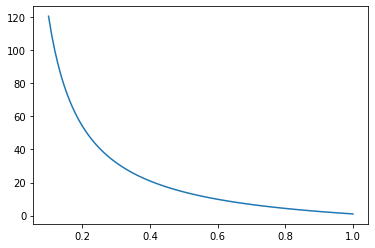

In [28]:
lista = [la.cond(shrunk_covariance(X.cov(), shrinkage=s)) for s in np.linspace(0.1, 1, 100)]
plt.plot(np.linspace(0.1,1,100), lista)

In [29]:
shrunk_S = shrunk_covariance(X.cov(), shrinkage=0.3)

In [30]:
la.cond(shrunk_covariance(X.cov(), shrinkage=0.3))

32.021582142835776

## PCA

In [31]:
shrunk_S.shape

(109, 109)

In [32]:
eig_values, eig_vectors = la.eig(shrunk_S)
eig_values.round(3)

array([8.285, 6.54 , 4.471, 3.043, 2.618, 2.028, 1.712, 1.603, 1.57 ,
       1.514, 1.456, 1.447, 1.393, 1.346, 1.333, 1.313, 1.308, 1.301,
       1.292, 1.278, 1.192, 1.164, 1.119, 1.085, 1.044, 1.022, 1.018,
       0.993, 0.971, 0.963, 0.96 , 0.957, 0.954, 0.941, 0.936, 0.918,
       0.915, 0.866, 0.833, 0.829, 0.789, 0.766, 0.725, 0.72 , 0.693,
       0.671, 0.647, 0.643, 0.624, 0.619, 0.613, 0.61 , 0.607, 0.593,
       0.578, 0.567, 0.564, 0.547, 0.538, 0.501, 0.488, 0.464, 0.465,
       0.42 , 0.417, 0.399, 0.365, 0.355, 0.353, 0.35 , 0.346, 0.341,
       0.327, 0.326, 0.323, 0.314, 0.317, 0.299, 0.294, 0.29 , 0.281,
       0.277, 0.274, 0.271, 0.27 , 0.269, 0.268, 0.263, 0.261, 0.259,
       0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
       0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
       0.259])

In [33]:
eig_values[0:50].sum()/eig_values.sum()

0.7811038142079254

In [34]:
reduced_X = []
for index, row in enumerate(X.to_numpy()):
  Z = [np.dot(eig_vectors[:,i], row) for i in range(0, 50)]
  columns_names = [f'Z{i + 1}' for i in range(0, 50)]
  reduced_X.append(Z)

reduced_X = pd.DataFrame(np.array(reduced_X), columns = columns_names)


In [35]:
reduced_X.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z50
0,4.030112,0.613749,-0.088251,-1.953125,0.997087,-2.147406,0.405212,0.179118,0.025118,0.142400,...,-0.409406,1.172643,0.697768,-1.083205,-1.050439,0.074196,0.472613,0.822124,0.099180,-0.613303
1,-1.369065,-0.404033,-2.582649,1.800864,0.458748,1.118063,1.124127,0.342163,0.578756,2.024368,...,-0.625627,-0.633995,0.057173,-0.486033,0.160425,-0.188034,-0.124814,-0.162731,-0.030564,-0.034036
2,4.351594,0.670487,-0.408545,-3.429050,-0.235766,0.620055,1.024959,-0.137220,-0.026811,-1.086383,...,-0.235128,0.691358,0.528219,-0.640395,-0.079394,-0.721660,0.149265,0.042149,-0.081083,-0.406523
3,-1.115859,-0.350217,-2.470215,1.580289,0.589497,-0.038024,-1.768462,-8.937583,1.133337,1.256421,...,0.234811,-0.494691,-0.389596,-0.673156,0.193484,-0.112184,0.060698,0.206921,0.009189,0.027810
4,-1.554116,-0.139809,-1.205703,1.019043,0.517757,1.906355,-0.659539,-0.167220,-0.129365,0.759112,...,-0.526257,1.526629,-0.743008,0.031946,0.387360,-0.336983,-0.402833,-0.901941,-0.147201,0.009463


In [36]:
reduced_X.mean().mean()

-2.2937355970488487e-14

In [37]:
d = []
S_i = la.inv(reduced_X.cov())
median = reduced_X.median()
for row in reduced_X.to_numpy():
    d.append(mahalanobis(row, median, S_i))
distances = pd.Series(d)


In [38]:
outliers = distances[distances > np.percentile(distances, 90)]
outliers

18        10.080911
24        10.768611
34        12.776805
35        10.376859
36        13.016751
            ...    
102756    11.158825
102790    10.333835
102795    14.101390
102796    10.088667
102798    10.950866
Length: 10280, dtype: float64

In [39]:
reduced_X['predict'] = 0

In [40]:
for i in outliers.index:
  reduced_X.predict[i] = 1

<ipython-input-40-df8d815afe54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_X.predict[i] = 1


In [41]:
reduced_X['isFraud'] = df.isFraud
reduced_X

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z50,predict,isFraud
0,4.030112,0.613749,-0.088251,-1.953125,0.997087,-2.147406,0.405212,0.179118,0.025118,0.142400,...,0.697768,-1.083205,-1.050439,0.074196,0.472613,0.822124,0.099180,-0.613303,0,0
1,-1.369065,-0.404033,-2.582649,1.800864,0.458748,1.118063,1.124127,0.342163,0.578756,2.024368,...,0.057173,-0.486033,0.160425,-0.188034,-0.124814,-0.162731,-0.030564,-0.034036,0,0
2,4.351594,0.670487,-0.408545,-3.429050,-0.235766,0.620055,1.024959,-0.137220,-0.026811,-1.086383,...,0.528219,-0.640395,-0.079394,-0.721660,0.149265,0.042149,-0.081083,-0.406523,0,0
3,-1.115859,-0.350217,-2.470215,1.580289,0.589497,-0.038024,-1.768462,-8.937583,1.133337,1.256421,...,-0.389596,-0.673156,0.193484,-0.112184,0.060698,0.206921,0.009189,0.027810,0,0
4,-1.554116,-0.139809,-1.205703,1.019043,0.517757,1.906355,-0.659539,-0.167220,-0.129365,0.759112,...,-0.743008,0.031946,0.387360,-0.336983,-0.402833,-0.901941,-0.147201,0.009463,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102795,13.395633,0.691108,-3.941100,-0.873612,0.107037,-6.366004,-1.354358,2.738094,0.461930,6.575819,...,-0.177083,-1.122832,-2.619403,1.667334,-0.913215,-1.810102,-0.062737,0.232121,1,0
102796,10.350589,0.385836,-5.384304,-3.175562,-1.732373,2.569703,0.060125,1.784562,0.200032,1.640758,...,-0.333055,-0.207072,-0.434362,0.301686,-0.377999,-0.736459,-0.153144,-0.147925,1,0
102797,-0.263510,-0.061175,-1.553438,0.964585,1.980083,-1.866315,0.345240,0.019409,0.008107,-2.153272,...,0.052169,0.433985,0.352766,1.083275,-0.374364,-0.807579,0.003142,-0.185899,0,0
102798,14.454841,1.142728,-2.350810,-2.360707,-0.950319,-8.722382,-1.218564,0.897550,0.117395,4.222708,...,0.922622,-1.036903,-2.940194,0.565816,-0.332144,-0.856531,0.001165,-0.158754,1,0


In [42]:
reduced_X.predict.value_counts()

0    92520
1    10280
Name: predict, dtype: int64

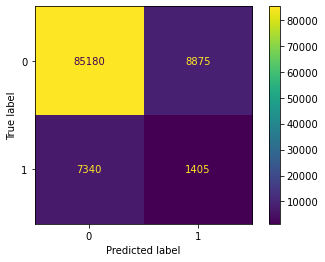

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_true=reduced_X.isFraud.to_numpy(), y_pred=reduced_X.predict.to_numpy())).plot()

In [44]:
print(f'Accuracy train: {accuracy_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'Precision train: {precision_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'Recall train: {recall_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'F1-score train: {f1_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')

Accuracy train: 0.8422665369649806
Precision train: 0.13667315175097275
Recall train: 0.16066323613493425
F1-score train: 0.14770039421813402


## PCA con covarianza habitual

In [45]:
S = X.cov()

In [46]:
eig_values, eig_vectors = la.eig(S)


In [47]:
eig_values[0:30].sum()/eig_values.sum()


0.7546859524440062

In [48]:
reduced_X = []
for index, row in enumerate(X.to_numpy()):
  Z = [np.dot(eig_vectors[:,i], row) for i in range(0, 30)]
  columns_names = [f'Z{i + 1}' for i in range(0, 30)]
  reduced_X.append(Z)

reduced_X = pd.DataFrame(np.array(reduced_X), columns = columns_names)

In [49]:
d = []
S_i = la.inv(reduced_X.cov())
median = reduced_X.median()
for row in reduced_X.to_numpy():
    d.append(mahalanobis(row, median, S_i))
distances = pd.Series(d)

In [50]:
outliers = distances[distances > np.percentile(distances, 91.5)]


In [51]:
reduced_X['predict'] = 0
for i in outliers.index:
  reduced_X.predict[i] = 1
reduced_X['isFraud'] = df.isFraud
reduced_X

<ipython-input-51-5e629884acfe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_X.predict[i] = 1


,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,predict,isFraud
0,4.030112,0.613749,-0.088251,-1.953125,0.997087,-2.147406,-0.405212,-0.179118,-0.025118,-0.142400,...,-0.594758,0.499388,0.310310,0.534613,0.635837,-0.676830,0.494064,-0.061804,0,0
1,-1.369065,-0.404033,-2.582649,1.800864,0.458748,1.118063,-1.124127,-0.342163,-0.578756,-2.024368,...,1.036428,1.268309,-0.501352,-0.015133,0.229772,0.763781,-0.238509,0.186483,0,0
2,4.351594,0.670487,-0.408545,-3.429050,-0.235766,0.620055,-1.024959,0.137220,0.026811,1.086383,...,0.328172,-0.556196,0.452644,1.045269,1.214327,-0.862078,0.748534,-0.119492,0,0
3,-1.115859,-0.350217,-2.470215,1.580289,0.589497,-0.038024,1.768462,8.937583,-1.133337,-1.256421,...,-1.575243,-0.237837,-0.101426,0.269146,1.363620,-0.958271,-0.398149,0.674756,0,0
4,-1.554116,-0.139809,-1.205703,1.019043,0.517757,1.906355,0.659539,0.167220,0.129365,-0.759112,...,0.618727,0.123207,-1.084485,-1.974435,-0.055828,0.981855,-0.748336,-0.004643,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102795,13.395633,0.691108,-3.941100,-0.873612,0.107037,-6.366004,1.354358,-2.738094,-0.461930,-6.575819,...,1.163599,1.250641,-2.772048,1.698376,2.347017,-0.765105,-1.371349,-0.889128,1,0
102796,10.350589,0.385836,-5.384304,-3.175562,-1.732373,2.569703,-0.060125,-1.784562,-0.200032,-1.640758,...,1.597747,0.655891,-3.507410,1.846424,0.433369,-0.058318,-0.710934,-1.291238,0,0
102797,-0.263510,-0.061175,-1.553438,0.964585,1.980083,-1.866315,-0.345240,-0.019409,-0.008107,2.153272,...,-1.407182,-1.019263,0.569145,0.242824,-1.228826,-0.393037,0.014164,0.204684,0,0
102798,14.454841,1.142728,-2.350810,-2.360707,-0.950319,-8.722382,1.218564,-0.897550,-0.117395,-4.222708,...,1.918497,0.108845,0.138884,-0.870813,0.359941,-0.538750,-0.569430,0.684988,1,0


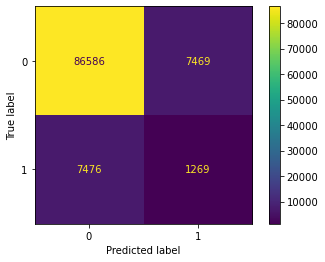

In [52]:
ConfusionMatrixDisplay(confusion_matrix(y_true=reduced_X.isFraud.to_numpy(), y_pred=reduced_X.predict.to_numpy())).plot()


In [53]:
print(f'Accuracy train: {accuracy_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'Precision train: {precision_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'Recall train: {recall_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')
print(f'F1-score train: {f1_score(reduced_X.isFraud.to_numpy(), reduced_X.predict.to_numpy())}')

Accuracy train: 0.8546206225680933
Precision train: 0.1452277409018082
Recall train: 0.1451114922813036
F1-score train: 0.14516959331922438


## PCA con Sklearn

In [353]:
pca = PCA(n_components=0.8, svd_solver="full")
pca_fit = pca.fit(X)
pca_fit.n_components_

35

In [357]:
X_pca = pd.DataFrame(pca_fit.transform(X), columns=[f'Z{i+1}' for i in range(0, pca_fit.n_components_)])
df_pca = pd.concat([X_pca, df.isFraud], axis=1)
df_pca

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,isFraud
0,4.030112,-0.613749,-0.088251,-1.953125,-0.997087,-2.147406,0.405212,-0.179118,-0.025118,0.142400,...,0.635837,-0.676830,-0.494064,0.061804,-0.002670,-0.393463,0.115778,0.275634,0.097064,0
1,-1.369065,0.404033,-2.582649,1.800864,-0.458748,1.118063,1.124127,-0.342163,-0.578756,2.024368,...,0.229772,0.763781,0.238509,-0.186483,0.268736,0.085893,0.109266,-0.513778,-0.563976,0
2,4.351594,-0.670487,-0.408545,-3.429050,0.235766,0.620055,1.024959,0.137220,0.026811,-1.086383,...,1.214327,-0.862078,-0.748534,0.119492,-0.307303,-0.346931,-0.039165,0.385463,0.210986,0
3,-1.115859,0.350217,-2.470215,1.580289,-0.589497,-0.038024,-1.768462,8.937583,-1.133337,1.256421,...,1.363620,-0.958271,0.398149,-0.674756,0.113614,-0.408716,0.062518,0.500005,0.766489,0
4,-1.554116,0.139809,-1.205703,1.019043,-0.517757,1.906355,-0.659539,0.167220,0.129365,0.759112,...,-0.055828,0.981855,0.748336,0.004643,0.099944,0.144370,-0.204803,-0.465735,-0.424934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102795,13.395633,-0.691108,-3.941100,-0.873612,-0.107037,-6.366004,-1.354358,-2.738094,-0.461930,6.575819,...,2.347017,-0.765105,1.371349,0.889128,-0.385483,-0.169311,-1.942535,0.544782,3.931133,0
102796,10.350589,-0.385836,-5.384304,-3.175562,1.732373,2.569703,0.060125,-1.784562,-0.200032,1.640758,...,0.433369,-0.058318,0.710934,1.291238,-0.225950,0.296433,-2.132963,0.239940,4.363399,0
102797,-0.263510,0.061175,-1.553438,0.964585,-1.980083,-1.866315,0.345240,-0.019409,-0.008107,-2.153272,...,-1.228826,-0.393037,-0.014164,-0.204684,0.095874,-0.203466,0.311656,0.334204,-0.186529,0
102798,14.454841,-1.142728,-2.350810,-2.360707,0.950319,-8.722382,-1.218564,-0.897550,-0.117395,4.222708,...,0.359941,-0.538750,0.569430,-0.684988,0.230274,-0.234789,0.745177,0.290870,0.628014,0


# Modelos supervisados

Primero debemos lidiar el desbalanceo de datos

## SMOTE

In [54]:
def multiple_corr(X):
    S = X.cov()
    S_inv = la.inv(S)
    R2 = 1 - 1 / (np.diag(S) * np.diag(S_inv))
    return pd.Series(R2, index=X.columns)

In [55]:
X_c = X.copy()
while True:
    R2 = multiple_corr(X_c).sort_values(ascending=False)
    if R2[0] > 0.7:
        X_c.drop(R2.index[0], axis=1, inplace=True)
    else:
        break

In [56]:
data = pd.concat([X_c, df.isFraud], axis=1)
data_train, data_test = train_test_split(data, train_size=0.7, random_state=42)

In [57]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(data_train.drop('isFraud', axis=1), data_train.isFraud)

In [58]:
balanced_df_train = pd.concat([X_res, y_res], axis=1)
balanced_df_train

,id_01,id_02,id_05,id_06,id_19,id_20,TransactionAmt,card1,card2,card3,...,R_emaildomain_comcast,R_emaildomain_icloud,R_emaildomain_live,R_emaildomain_msn,R_emaildomain_other,R_emaildomain_outlook,R_emaildomain_sbcglobal,R_emaildomain_verizon,R_emaildomain_yahoo,isFraud
0,0.358838,-0.798808,-0.301125,0.360888,-0.591719,-0.622561,-0.257248,-0.042453,-1.793494,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
1,0.017014,0.563205,-0.301125,-0.088505,-1.406504,1.085285,0.053685,-0.770238,-1.016432,-2.822354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.358838,-0.922550,-0.301125,0.360888,0.367276,-1.469864,0.098129,1.035797,0.761489,-0.635158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,0.358838,-0.781059,-0.100105,-0.537899,0.028383,-1.171984,1.048005,-1.135621,0.046591,-0.635158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.805059,0.0,0
4,0.358838,0.084822,-0.301125,0.360888,-0.591719,0.714589,-0.235942,-1.332933,0.102539,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131641,0.358838,1.835245,-0.301125,0.360888,-1.406504,-0.490170,-0.595868,0.012245,-1.551051,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
131642,0.427396,-0.295658,0.020848,0.360888,-0.609073,-0.301455,-0.647839,0.490324,-1.333473,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
131643,-0.230477,0.388191,-0.301125,0.360888,-0.591719,-0.055394,-0.323062,1.290989,-0.419647,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
131644,0.358838,1.699948,-0.039985,0.360888,-1.175968,1.107926,-0.187286,-1.012421,0.366540,1.104658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [59]:
balanced_df_train.isFraud.value_counts()

0    65823
1    65823
Name: isFraud, dtype: int64

In [60]:
logit = LogisticRegressionCV(Cs=20, scoring='precision', solver='sag', max_iter=752, n_jobs=6)

In [61]:
logit_fit = logit.fit(X_res, y_res)

In [62]:
y_pred_train = logit_fit.predict(X_res)

In [63]:
confusion_matrix(y_res, y_pred_train)


array([[52615, 13208],
       [15430, 50393]], dtype=int64)

In [64]:
y_pred_test = logit_fit.predict(data_test.drop('isFraud', axis=1))

In [65]:
confusion_matrix(data_test.isFraud, y_pred_test)


array([[22578,  5654],
       [  651,  1957]], dtype=int64)

## KNN

In [67]:
knn = KNeighborsClassifier(n_jobs=8)
parameters = {'n_neighbors': range(1, 21)}
clf = GridSearchCV(knn, parameters)
clf_fit = clf.fit(X_res, y_res)

In [68]:
clf_fit.best_params_

{'n_neighbors': 2}

In [69]:
y_pred_train = clf_fit.predict(X_res)
confusion_matrix(y_res, y_pred_train)

array([[65823,     0],
       [   66, 65757]], dtype=int64)

In [70]:
y_pred_test = clf_fit.predict(data_test.drop('isFraud', axis=1))

In [71]:
confusion_matrix(data_test.isFraud, y_pred_test)


array([[26972,  1260],
       [  961,  1647]], dtype=int64)

## Random Forest

In [81]:
random_forest = RandomForestClassifier(criterion='entropy', random_state=42, n_jobs=10)
parameters = {
    'n_estimators': range(100, 301, 50), 
    'max_depth': range(2,9),
    'min_samples_leaf': range(2, 6),
    'min_samples_split': range(2, 6)
    }
forest_clf = GridSearchCV(random_forest, parameters)
forest_clf_fit = forest_clf.fit(X_res, y_res)

In [281]:
forest_clf_fit.best_params_

{'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

In [83]:
y_pred_train = forest_clf_fit.predict(X_res)

In [84]:
confusion_matrix(y_res, y_pred_train)

array([[61261,  4562],
       [ 6503, 59320]], dtype=int64)

In [97]:
y_pred_test = forest_clf_fit.predict(data_test.drop('isFraud', axis=1))

In [98]:
confusion_matrix(data_test.isFraud, y_pred_test)


array([[26231,  2001],
       [  839,  1769]], dtype=int64)

## CV con recall como scoring

In [ ]:
logit2 = LogisticRegression(solver='sag', max_iter=752, n_jobs=10)
parameters2 = {'C': np.linspace(0.05, 1, 20)}
logit_clf2 = GridSearchCV(logit2, parameters2, scoring='recall')
logit_fit2 = logit_clf2.fit(X_res, y_res)

In [272]:
dump(logit_fit2, "./models/logit_clf_2.joblib")

['./models/logit_clf_2.joblib']

In [247]:
logit_fit2.best_params_

{'C': 0.3}

In [248]:
y_pred_train2 = logit_fit2.predict(X_res)

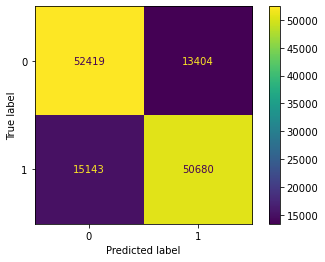

In [249]:
ConfusionMatrixDisplay(confusion_matrix(y_res, y_pred_train2)).plot()


In [250]:
print(f'Accuracy train: {accuracy_score(y_res, y_pred_train2)}')
print(f'Precision train: {precision_score(y_res, y_pred_train2)}')
print(f'Recall train: {recall_score(y_res, y_pred_train2)}')
print(f'F1-score train: {f1_score(y_res, y_pred_train2)}')

Accuracy train: 0.7831533050757334
Precision train: 0.7908370264028463
Recall train: 0.7699436367227261
F1-score train: 0.7802504868867728


In [251]:
y_pred_test2 = logit_fit2.predict(data_test.drop('isFraud', axis=1))

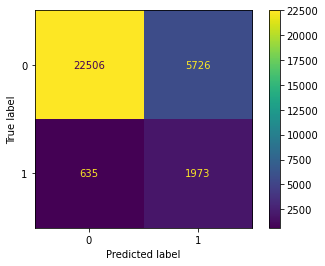

In [252]:
ConfusionMatrixDisplay(confusion_matrix(data_test.isFraud, y_pred_test2)).plot()


In [253]:
print(f'Accuracy test: {accuracy_score(data_test.isFraud, y_pred_test2)}')
print(f'Precision test: {precision_score(data_test.isFraud, y_pred_test2)}')
print(f'Recall test: {recall_score(data_test.isFraud, y_pred_test2)}')
print(f'F1-score test: {f1_score(data_test.isFraud, y_pred_test2)}')

Accuracy test: 0.7937418936446173
Precision test: 0.25626704766852837
Recall test: 0.7565184049079755
F1-score test: 0.3828466091006112


In [128]:
knn2 = KNeighborsClassifier(n_jobs=10)
parameters2 = {'n_neighbors': range(1, 21)}
clf2 = GridSearchCV(knn, parameters2, scoring='recall')
clf_fit2 = clf2.fit(X_res, y_res)

In [254]:
clf_fit2.best_params_

{'n_neighbors': 3}

In [273]:
dump(clf_fit2, "./models/knn_clf_2.joblib")

['./models/knn_clf_2.joblib']

In [255]:
y_pred_train2 = clf_fit2.predict(X_res)

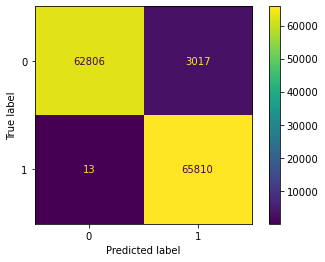

In [256]:
ConfusionMatrixDisplay(confusion_matrix(y_res, y_pred_train2)).plot()

In [257]:
print(f'Accuracy train: {accuracy_score(y_res, y_pred_train2)}')
print(f'Precision train: {precision_score(y_res, y_pred_train2)}')
print(f'Recall train: {recall_score(y_res, y_pred_train2)}')
print(f'F1-score train: {f1_score(y_res, y_pred_train2)}')

Accuracy train: 0.9769837290916549
Precision train: 0.9561654583230418
Recall train: 0.999802500645671
F1-score train: 0.9774972150018567


In [258]:
y_pred_test2 = clf_fit2.predict(data_test.drop('isFraud', axis=1))

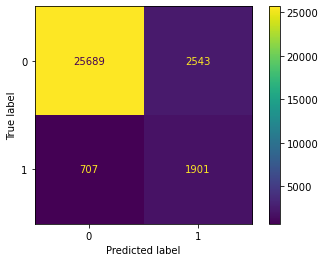

In [259]:
ConfusionMatrixDisplay(confusion_matrix(data_test.isFraud, y_pred_test2)).plot()


In [260]:
print(f'Accuracy test: {accuracy_score(data_test.isFraud, y_pred_test2)}')
print(f'Precision test: {precision_score(data_test.isFraud, y_pred_test2)}')
print(f'Recall test: {recall_score(data_test.isFraud, y_pred_test2)}')
print(f'F1-score test: {f1_score(data_test.isFraud, y_pred_test2)}')

Accuracy test: 0.8946173800259404
Precision test: 0.42776777677767774
Recall test: 0.7289110429447853
F1-score test: 0.5391378332387975


In [133]:
random_forest2 = RandomForestClassifier(criterion='entropy', random_state=42, n_jobs=10)
parameters2 = {
    'n_estimators': range(100, 301, 50), 
    'max_depth': range(2,9),
    'min_samples_leaf': range(2, 6),
    'min_samples_split': range(2, 6)
    }
forest_clf2 = GridSearchCV(random_forest2, parameters2, scoring='recall')
forest_clf_fit2 = forest_clf2.fit(X_res, y_res)

In [261]:
forest_clf_fit2.best_params_

{'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [274]:
dump(forest_clf_fit2, "./models/forest_clf_2.joblib")

['./models/forest_clf_2.joblib']

In [262]:
y_pred_train2 = forest_clf_fit2.predict(X_res)

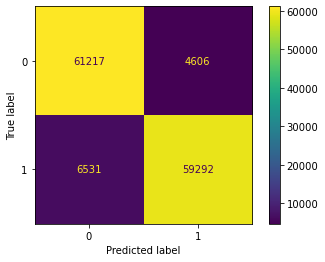

In [263]:
ConfusionMatrixDisplay(confusion_matrix(y_res, y_pred_train2)).plot()

In [264]:
print(f'Accuracy train: {accuracy_score(y_res, y_pred_train2)}')
print(f'Precision train: {precision_score(y_res, y_pred_train2)}')
print(f'Recall train: {recall_score(y_res, y_pred_train2)}')
print(f'F1-score train: {f1_score(y_res, y_pred_train2)}')

Accuracy train: 0.9154019111860596
Precision train: 0.9279163667094432
Recall train: 0.9007793628366985
F1-score train: 0.9141465144425345


In [265]:
y_pred_test2 = forest_clf_fit2.predict(data_test.drop('isFraud', axis=1))

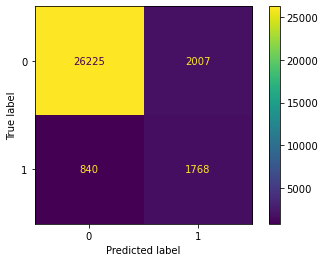

In [266]:
ConfusionMatrixDisplay(confusion_matrix(data_test.isFraud, y_pred_test2)).plot()

In [267]:
print(f'Accuracy test: {accuracy_score(data_test.isFraud, y_pred_test2)}')
print(f'Precision test: {precision_score(data_test.isFraud, y_pred_test2)}')
print(f'Recall test: {recall_score(data_test.isFraud, y_pred_test2)}')
print(f'F1-score test: {f1_score(data_test.isFraud, y_pred_test2)}')

Accuracy test: 0.9076848249027237
Precision test: 0.4683443708609272
Recall test: 0.6779141104294478
F1-score test: 0.5539714867617107


## Modelos Supervisados con PCA

In [358]:
# Train test split
data_pca_train, data_pca_test = train_test_split(df_pca, train_size=0.7, random_state=42)

### Rebalanceo

In [359]:
sm = SMOTE(random_state = 42)
X_pca_res, y_pca_res = sm.fit_resample(data_pca_train.drop('isFraud', axis=1), data_pca_train.isFraud)

### Regresión Logística

In [362]:
logit_pca = LogisticRegression(solver='sag', max_iter=752, n_jobs=10)
parameters = {'C': np.linspace(0.1, 1, 10)}
logit_pca_clf = GridSearchCV(logit_pca, parameters, scoring='recall')
logit_pca_fit = logit_pca_clf.fit(X_pca_res, y_pca_res)

In [389]:
dump(logit_pca_fit, "./models/pca/logit_pca.joblib")
logit_pca_fit.best_params_

{'C': 0.9}

In [364]:
y_pred_train = logit_pca_fit.predict(X_pca_res)

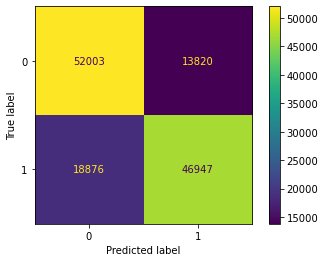

In [365]:
ConfusionMatrixDisplay(confusion_matrix(y_pca_res, y_pred_train)).plot()


In [366]:
print(f'Accuracy train: {accuracy_score(y_pca_res, y_pred_train)}')
print(f'Precision train: {precision_score(y_pca_res, y_pred_train)}')
print(f'Recall train: {recall_score(y_pca_res, y_pred_train)}')
print(f'F1-score train: {f1_score(y_pca_res, y_pred_train)}')

Accuracy train: 0.7516369658022272
Precision train: 0.7725739299290734
Recall train: 0.7132309375142427
F1-score train: 0.7417173552413302


In [367]:
y_pred_test = logit_pca_fit.predict(data_pca_test.drop('isFraud', axis=1))

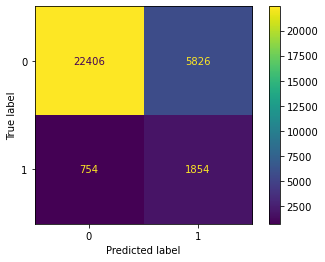

In [368]:
ConfusionMatrixDisplay(confusion_matrix(data_pca_test.isFraud, y_pred_test)).plot()


In [369]:
print(f'Accuracy test: {accuracy_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Precision test: {precision_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Recall test: {recall_score(data_pca_test.isFraud, y_pred_test)}')
print(f'F1-score test: {f1_score(data_pca_test.isFraud, y_pred_test)}')

Accuracy test: 0.7866407263294423
Precision test: 0.24140625
Recall test: 0.7108895705521472
F1-score test: 0.36041990668740276


## KNN

In [370]:
knn_pca = KNeighborsClassifier(n_jobs=10)
parameters = {'n_neighbors': range(1, 8)}
knn_pca_clf = GridSearchCV(knn_pca, parameters, scoring='recall')
knn_pca_fit = knn_pca_clf.fit(X_pca_res, y_pca_res)

In [390]:
dump(knn_pca_fit, "./models/pca/knn_pca.joblib")
knn_pca_fit.best_params_

{'n_neighbors': 1}

In [372]:
y_pred_train = knn_pca_fit.predict(X_pca_res)

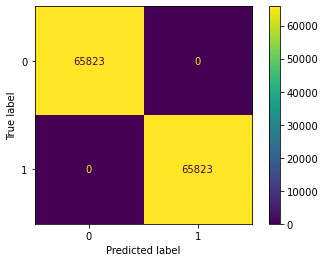

In [373]:
ConfusionMatrixDisplay(confusion_matrix(y_pca_res, y_pred_train)).plot()

In [374]:
print(f'Accuracy train: {accuracy_score(y_pca_res, y_pred_train)}')
print(f'Precision train: {precision_score(y_pca_res, y_pred_train)}')
print(f'Recall train: {recall_score(y_pca_res, y_pred_train)}')
print(f'F1-score train: {f1_score(y_pca_res, y_pred_train)}')

Accuracy train: 1.0
Precision train: 1.0
Recall train: 1.0
F1-score train: 1.0


In [375]:
y_pred_test = knn_pca_fit.predict(data_pca_test.drop('isFraud', axis=1))

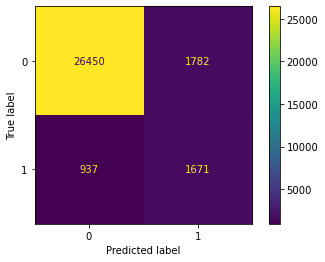

In [376]:
ConfusionMatrixDisplay(confusion_matrix(data_pca_test.isFraud, y_pred_test)).plot()


In [377]:
print(f'Accuracy test: {accuracy_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Precision test: {precision_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Recall test: {recall_score(data_pca_test.isFraud, y_pred_test)}')
print(f'F1-score test: {f1_score(data_pca_test.isFraud, y_pred_test)}')

Accuracy test: 0.9118352788586251
Precision test: 0.48392701998262383
Recall test: 0.6407208588957055
F1-score test: 0.5513941593796403


### Random Forest

In [381]:
random_forest_pca = RandomForestClassifier(criterion='entropy' ,min_samples_split=2, random_state=42, n_jobs=10)
parameters = {
    'n_estimators': range(100, 301, 50), 
    'max_depth': range(2,9),
    'min_samples_leaf': range(2, 6),
    }
forest_pca_clf = GridSearchCV(random_forest_pca, parameters, scoring='recall')
forest_pca_fit = forest_pca_clf.fit(X_pca_res, y_pca_res)

In [391]:
dump(forest_pca_fit, "./models/pca/forest_pca.joblib")
forest_pca_fit.best_params_

{'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 200}

In [383]:
y_pred_train = forest_pca_fit.predict(X_pca_res)

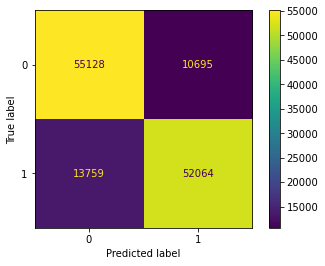

In [384]:
ConfusionMatrixDisplay(confusion_matrix(y_pca_res, y_pred_train)).plot()

In [385]:
print(f'Accuracy train: {accuracy_score(y_pca_res, y_pred_train)}')
print(f'Precision train: {precision_score(y_pca_res, y_pred_train)}')
print(f'Recall train: {recall_score(y_pca_res, y_pred_train)}')
print(f'F1-score train: {f1_score(y_pca_res, y_pred_train)}')

Accuracy train: 0.814244261124531
Precision train: 0.8295861948087127
Recall train: 0.7909697218297556
F1-score train: 0.8098178594204477


In [386]:
y_pred_test = forest_pca_fit.predict(data_pca_test.drop('isFraud', axis=1))

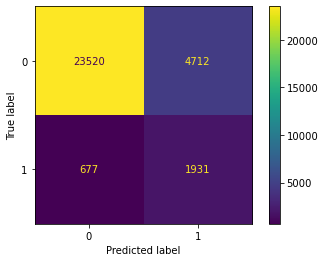

In [387]:
ConfusionMatrixDisplay(confusion_matrix(data_pca_test.isFraud, y_pred_test)).plot()

In [388]:
print(f'Accuracy test: {accuracy_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Precision test: {precision_score(data_pca_test.isFraud, y_pred_test)}')
print(f'Recall test: {recall_score(data_pca_test.isFraud, y_pred_test)}')
print(f'F1-score test: {f1_score(data_pca_test.isFraud, y_pred_test)}')

Accuracy test: 0.8252594033722438
Precision test: 0.29068192081890715
Recall test: 0.7404141104294478
F1-score test: 0.41746838179656254
